#### 构建一个可迭代的类来模拟一个村庄中，农民与工匠间的贸易：

基本假设：村民们每天需要消耗1份粮食，农民花0.3天并消耗一份工具就能产出一份粮食，但缺乏工具时生产效率会降低，不消耗工具时手刨粮食需要0.8天产出一份(因此将农民生产每份工具的时间近似为0.5天，且农民每天消耗种地时间量的工具)；

农民生产粮食，工具的时间消耗为[0.3, 0.5]；

工匠生产粮食，工具的时间消耗为[0.7, 0.2]。

因此每个村民都具有如下属性：

  生产属性，通过生产单位产品所需的时间衡量；
  
  消耗属性，每日消耗的产品份数；
  
  生产耗时，在生产某种产品上消耗的时间；
  
  贸易量，各商品的卖出，买入份数；
  
  库存状态，每天的(生产-消耗+贸易)量将被加入其中。越缺乏某种产品，越有动力去通过工作或贸易获得之。
  
先考虑不含贸易的类:
每一位村民的初始库存全部为0，他每天消耗在某项产品上的工作时长 = -库存 × 0.1 × 生产效率，

因此村民的产品消耗量为[1,农产品工作时长]

5.1 改进：通过将不容忍改为生产时间将货物均衡点改为-5，并将产品消耗锁定与产量直接挂钩

In [59]:
import numpy as np

def normalize_1(matrix):
    """
    归一化矩阵：将矩阵的每一行除以该行的第一列值。
    """
    matrix = np.array(matrix, dtype=float)  # 确保是 NumPy 数组，并转换为浮点数
    return matrix[:, 1:] / matrix[:, 0][:, np.newaxis]  # 每行除以第一列的值

def row_sums(matrix):
    """
    计算矩阵的行和。
    """
    matrix = np.array(matrix, dtype=float)
    return np.sum(matrix, axis=1)  # 按行求和

class Block1(object): 
    def __init__(self, csp, p_t, itl, status, worktime, tps):
        """
        经济模拟系统中的区块（Block1）类。
        
        参数：
        - n: 区块中职业种类数
        - csp: 消费矩阵（职业数量 × 商品种类），表示各职业人口的商品消耗量
        - p_t: 生产时间矩阵（职业数量 × 商品种类），表示生产一单位商品所需时间
        - itl: 商品缺乏耐受度矩阵（职业数量 × 商品种类）
        - sts: 状态张量（时间 × 职业数量 × 商品种类），表示库存状态
        - wts: 工作时间张量（时间 × 职业数量 × 商品种类），表示每日生产所花费的时间
        - tps: 商品基准价格列表
        """
        
        # 确保所有矩阵数据都是 NumPy 数组
        self.consumption = np.array(csp, dtype=float)  # 商品消耗量
        self.product_time = np.array(p_t, dtype=float)  # 生产单位商品所需时间
        self.intolerance = np.array(itl, dtype=float)  # 缺乏商品的耐受度
        
        # 计算可承受的最高买入价格/最低卖出价
        self.aff_price = normalize_1(self.product_time)  
        
        # 状态和工作时间存储为张量（时间序列）
        self.status = np.array(status, dtype=float)  # 库存状态序列
        self.worktime = np.array(worktime, dtype=float)  # 工作时间序列
    
    def evolution(self, consumption):
        """
        经济演化过程。
        
        """
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度）
        self.worktime = -self.status * self.product_time * 0.2
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime / self.product_time
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
        self.consumption[:,1] = production[:,0]
        
        # 计算总劳动负担（每个职业的工作时间总和）
        loading = row_sums(self.worktime)
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption

In [60]:
# 创建实例
Status = [];
Worktimes = [];
couple = Block1( 
               [[1, 0], [1, 0]], 
               [[0.3, 0.6], [0.5, 0.2]], 
               [[0.2, 0.05], [0.2, 0.05]], 
               [[0, 0], [0, 0]], 
               [[[0, 0], [0, 0]]], 
               [[1]])
for i in range(60):
    couple.evolution([[1, 0], [1, 0]])
    Status.append(couple.status)
    Worktimes.append(couple.worktime)

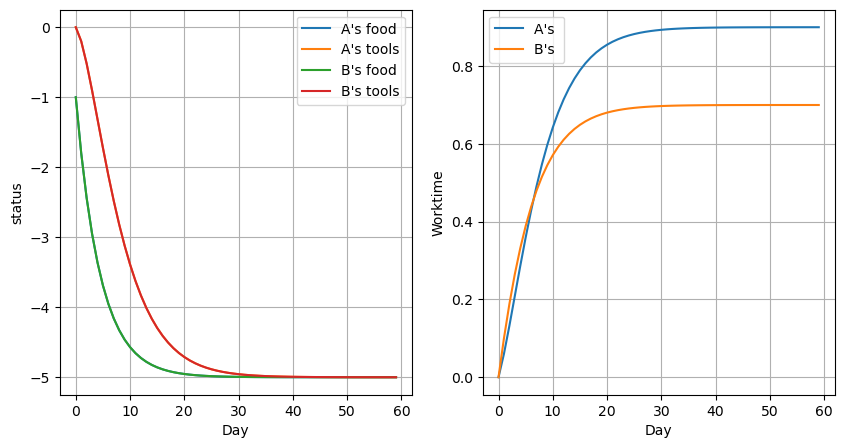

In [61]:
import matplotlib.pyplot as plt
names = ["A's ", "B's "];
goods = ["food", "tools", "gold"];
final = Status
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x=range(0,len(final))
def fun_fianl(x,i,j):
    return [final[y][i][j] for y in x]
for i in range(len(final[0])):
    for j in range(len(final[0][1])):
        ax[0].plot(x, fun_fianl(x,i,j),label = names[i]+goods[j])
ax[0].set_xlabel('Day')
ax[0].set_ylabel('status')
ax[0].legend(loc='best')
ax[0].grid()
y = np.array(list(map(row_sums,Worktimes))).T
for i in range(len(y)):
    ax[1].plot(x,y[i], label = names[i])
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Worktime')
ax[1].legend(loc='best')
ax[1].grid()

商品定价：每次交易计算 供需比例=(供应-需求)/(供应+需求),下次价格为 价格×EXP(供需比例)

购买行为：得知自己的优势商品后，购买所有值得的不容忍量，并希望出售等价值的商品

In [152]:
import numpy as np
import copy

def normalize_1(matrix):
    """
    归一化矩阵：将矩阵的每一行除以该行的第一列值。
    """
    matrix = np.array(matrix, dtype=float)  # 确保是 NumPy 数组，并转换为浮点数
    return matrix[:, 1:] / matrix[:, 0][:, np.newaxis]  # 每行除以第一列的值

def row_sums(matrix):
    """
    计算矩阵的行和。
    """
    matrix = np.array(matrix, dtype=float)
    return np.sum(matrix, axis=1)  # 按行求和

class Block1(object): 
    def __init__(self, csp, p_t, itl, status, worktime, tps):
        """
        经济模拟系统中的区块（Block1）类。
        
        参数：
        - n: 区块中职业种类数
        - csp: 消费矩阵（职业数量 × 商品种类），表示各职业人口的商品消耗量
        - p_t: 生产时间矩阵（职业数量 × 商品种类），表示生产一单位商品所需时间
        - itl: 商品缺乏耐受度矩阵（职业数量 × 商品种类）
        - sts: 状态张量（时间 × 职业数量 × 商品种类），表示库存状态
        - wts: 工作时间张量（时间 × 职业数量 × 商品种类），表示每日生产所花费的时间
        - tps: 商品基准价格列表
        """
        
        # 确保所有矩阵数据都是 NumPy 数组
        self.consumption = np.array(csp, dtype=float)  # 商品消耗量
        self.product_time = np.array(p_t, dtype=float)  # 生产单位商品所需时间
        self.intolerance = np.array(itl, dtype=float)  # 缺乏商品的耐受度
        
        # 计算可承受的最高买入价格/最低卖出价
        self.aff_price = normalize_1(self.product_time)  
        
        # 状态和工作时间存储为张量（时间序列）
        self.status = np.array(status, dtype=float)  # 库存状态序列
        self.worktime = np.array(worktime, dtype=float)  # 工作时间序列
        self.tradeprices = np.array(tps, dtype=float) # 商品的市场价格
        self.category = len(tps) # 商品种类的数目
        self.N = len(status) # 职业数
    
    def evolution(self, consumption):
        """
        经济演化过程。
        
        """
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度）
        self.worktime = -self.status * self.product_time * 0.2
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime / self.product_time
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
        self.consumption[:,1] = production[:,0]
        
        # 计算各职业的体感价格(生产某商品时赚取单位价值所需的时间，并倾向于生产效率最高的产品)
        self.feel_price = self.product_time / self.tradeprices
        # 找到对某职业相对最优势的商品序号
        self.choice = np.array(np.argmin(couple.feel_price, axis=1),dtype=int)
        
        #计算每日拟购买的商品量（去除优势商品后，购买所有其他商品）
        self.buy = copy.copy(self.consumption)
        self.buy[range(self.N), self.choice] = 0
        #计算在市场上拟支出的金额（商品消耗量 × 商品价值）
        self.expend = self.buy * self.tradeprices[self.choice]
        #计算在市场上拟出售的(优势)商品数量
        self.sell = np.sum(self.expend, axis=1) / self.tradeprices[self.choice]
        #计算供应量（将出售量放入商品种类对应的位置）
        self.provide = np.zeros(self.category)
        np.add.at(self.provide, self.choice, self.sell)
        
        
        # 计算总劳动负担（每个职业的工作时间总和）
        loading = row_sums(self.worktime)
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption

In [150]:
# 创建实例
Status = [];
Worktimes = [];
couple = Block1( 
               [[1, 0], [1, 0]], 
               [[0.5, 0.2],[0.3, 0.6]], 
               [[0.2, 0.05], [0.2, 0.05]], 
               [[0, 0], [0, 0]], 
               [[[0, 0], [0, 0]]], 
               [1,1.2])
for i in range(60):
    couple.evolution([[1, 0], [1, 0]])
    Status.append(couple.status)
    Worktimes.append(couple.worktime)

In [153]:
# 参数检查
for attr, value in vars(couple).items():
    print(f"{attr} = {value}")

consumption = [[1.         0.99999808]
 [1.         0.99999808]]
product_time = [[0.5 0.2]
 [0.3 0.6]]
intolerance = [[0.2  0.05]
 [0.2  0.05]]
aff_price = [[0.4]
 [2. ]]
status = [[-4.99999234 -4.9998774 ]
 [-4.99999234 -4.9998774 ]]
worktime = [[0.49999904 0.19999397]
 [0.29999943 0.5999819 ]]
tradeprices = [1.  1.2]
category = 2
N = 2
feel_price = [[0.5        0.16666667]
 [0.3        0.5       ]]
choice = [1 0]
buy = [[1.         0.        ]
 [0.         0.99999808]]
expend = [[1.2        0.        ]
 [0.         0.99999808]]
sell = [1.         0.99999808]
provide = [0.99999808 1.        ]


In [144]:
import numpy as np

# 原始矩阵（3行3列）
mat = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# 每一行中要变成0的列索引
a = np.array([0, 2, 1])  # 表示 mat[0,0], mat[1,2], mat[2,1] 要设为0

# 构造行索引 [0, 1, 2]
rows = range(len(a))

# 使用 NumPy 高级索引，一步置零
mat[rows, a] = 0

# 打印结果
print(mat)


[[0 2 3]
 [4 5 0]
 [7 0 9]]
